## Scénario
Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Ainsi, vous proposez une régression linéaire avec 3 variables :

- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question.

# Mission 2

In [1]:
# Importation des librairies nécessaire à l'analyse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans
import plotly.express as px

#Paramètres de style de nos prochains graphique
plt.style.use('ggplot')

# Importation de mon dataframe de travail
df = pd.read_csv('df.csv')

# Visualisation du dataframe
df.head()

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income_x,moyenne_income_y,moyenne_income_x.1,moyenne_income_y.1
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902
1,Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902
2,Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902
3,Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902
4,Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902


### Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique

In [2]:
# Calculons le revenu moyen pour chaque pays
df_revenu_moyen = df[['country_code', 'income']]
df_revenu_moyen = df_revenu_moyen.groupby(['country_code']).mean(['income']).reset_index()
df_revenu_moyen.rename(columns={"income" : "moyenne_income"}, inplace = True)
df_revenu_moyen.head()

,country_code,moyenne_income
0,ALB,2994.829902
1,ARG,5847.884654
2,ARM,1628.382785
3,AUT,16637.600204
4,AZE,2357.429023


In [3]:
# Injectons les moyennes de chaque pays dans notre dataframe de travail
df = df.merge(df_revenu_moyen, how = 'left', on = 'country_code')
df.head()

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income_x,moyenne_income_y,moyenne_income_x.1,moyenne_income_y.1,moyenne_income
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902
1,Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902
2,Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902
3,Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902
4,Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902


In [4]:
# Changement d'index par le nom des pays
df.set_index('country', inplace = True)

In [5]:
# Création d'une copie de notre dataframe
df_clustering = df.copy()

# Mise à l'écart de l'individu 'Fiji' dans notre dataframe car il s'agit d'un outliers qui aura une grosse influence sur notre clustering
df_clustering = df_clustering[df_clustering.index != 'Fiji']

In [6]:
# Pour alléger le temps de calcul nous allons effectuer notre clustering sur le premier quantile de chaque pays
df_clustering.drop_duplicates(subset = ['country_code'], inplace = True)
df_clustering

,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income_x,moyenne_income_y,moyenne_income_x.1,moyenne_income_y.1,moyenne_income
country,,,,,,,,,,,,,
Albania,ALB,2008,1,100,728.897950,7297.00000,3002678.0,0.30,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902
Argentina,ARG,2008,1,100,254.089420,13220.00000,40080160.0,0.45,5847.884654,5847.884654,5847.884654,5847.884654,5847.884654
Armenia,ARM,2008,1,100,366.617800,5611.00000,2907618.0,0.29,1628.382785,1628.382785,1628.382785,1628.382785,1628.382785
Austria,AUT,2008,1,100,2958.076400,36193.00000,8341532.0,0.30,16637.600204,16637.600204,16637.600204,16637.600204,16637.600204
Azerbaijan,AZE,2008,1,100,397.539830,8101.00000,8821873.0,0.31,2357.429023,2357.429023,2357.429023,2357.429023,2357.429023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,VNM,2006,1,100,234.266950,2578.00000,84617540.0,0.36,1377.773966,1377.773966,1377.773966,1377.773966,1377.773966
Occupied Palestinian Territory,PSE,2009,1,100,195.289900,3951.20000,3957670.0,0.36,1114.098514,1114.098514,1114.098514,1114.098514,1114.098514
Yemen,YEM,2008,1,100,162.951310,2224.00000,21892146.0,0.37,1042.635870,1042.635870,1042.635870,1042.635870,1042.635870


In [7]:
# Préparation des données pour le clustering du KMeans
X = df_clustering.loc[:, ['gdpppp', 'gini']].values
Y = df_clustering.index

In [8]:
# Centrage et réduction de nos valeurs
# Standardisations de nos valeurs
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

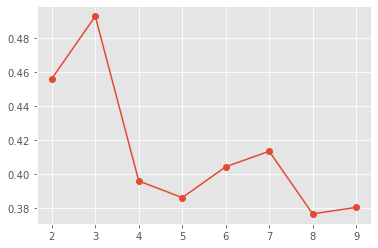

In [9]:
# Calcul de nombre de cluster selon la méthode 'silhoutte'
silhouette = []

# Création d'un boucle for pour tester plusieurs possiblités
for k in range(2, 10):
    # Instanciation de notre modèle
    cls = cluster.KMeans(n_clusters = k) # sélection du model
    cls.fit(X_scaled) # Entrainement du modèle par rapport aux valeurs centré & réduite
    
    # Stockage des coéfficients obtenus par le KMeans
    silh = metrics.silhouette_score(X_scaled, cls.labels_) # Récupération du coeff optimal du nombre de cluster
    silhouette.append(silh)

# Création de notre graphique sur le nombre optimal de cluster à sélectionner
plt.plot(range(2, 10), silhouette, marker = 'o')
plt.savefig("Graphs/nombre_de_cluster_à_selectionner.png")
plt.show()

La méthode silhoutte nous indique que k=3 est le meilleur choix du nombre de cluster sur nos données.

In [10]:
# répétons notre KMeans avec un k=3
cls = cluster.KMeans(n_clusters = 3)
cls.fit(X_scaled)

KMeans(n_clusters=3)

In [11]:
# Affichons les centroïdes de nos clusters
centroides = cls.cluster_centers_
df_centroides = pd.DataFrame(data = centroides, columns = [['gdpppp', 'gini']], index = [['cluster 0', 'cluster 1', 'cluster 2']])
df_centroides

,gdpppp,gini
cluster 0,-0.470642,-0.489378
cluster 1,-0.461260,1.224121
cluster 2,1.597693,-0.763262


In [12]:
# Index de nos clusters qui sont trié par la fonction "argsort"
idr = np.argsort(cls.labels_)

# Affichage dans un dataframe de nos cluster 'indexé'
df_cls = pd.DataFrame(df_clustering.index[idr], cls.labels_[idr]).reset_index()
df_cls.rename(columns={"index" : "clusters"}, inplace = True)

In [13]:
# Jointure de nos deux dataframe
df_cls = pd.merge(df_clustering, df_cls, on = 'country')
df_cls.head()

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income_x,moyenne_income_y,moyenne_income_x.1,moyenne_income_y.1,moyenne_income,clusters
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.30,2994.829902,2994.829902,2994.829902,2994.829902,2994.829902,0
1,Argentina,ARG,2008,1,100,254.08942,13220.0,40080160.0,0.45,5847.884654,5847.884654,5847.884654,5847.884654,5847.884654,1
2,Armenia,ARM,2008,1,100,366.61780,5611.0,2907618.0,0.29,1628.382785,1628.382785,1628.382785,1628.382785,1628.382785,0
3,Austria,AUT,2008,1,100,2958.07640,36193.0,8341532.0,0.30,16637.600204,16637.600204,16637.600204,16637.600204,16637.600204,2
4,Azerbaijan,AZE,2008,1,100,397.53983,8101.0,8821873.0,0.31,2357.429023,2357.429023,2357.429023,2357.429023,2357.429023,0


In [14]:
# Combien de pays compose mes différents cluster
print("Il y a {} pays dans mon cluster 0".format(len(df_cls[df_cls.clusters == 0])))
print("Il y a {} pays dans mon cluster 1".format(len(df_cls[df_cls.clusters == 1])))
print("Il y a {} pays dans mon cluster 2".format(len(df_cls[df_cls.clusters == 2])))

Il y a 52 pays dans mon cluster 0
Il y a 37 pays dans mon cluster 1
Il y a 26 pays dans mon cluster 2


In [15]:
# Liste des pays dans mon cluster 0
print(list(df_cls[df_cls.clusters == 0]['country']))
print("----------------------------------------------------------------------------------------------")
# Liste des pays dans mon cluster 1
print(list(df_cls[df_cls.clusters == 1]['country']))
print("----------------------------------------------------------------------------------------------")
# Liste des pays dans mon cluster 2
print(list(df_cls[df_cls.clusters == 2]['country']))

['Albania', 'Armenia', 'Azerbaijan', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bosnia and Herzegovina', 'Belarus', 'Bhutan', 'Egypt', 'Estonia', 'Georgia', 'Guinea', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Iraq', 'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Cambodia', 'Republic of Korea', 'Kosovo', "Lao People's Democratic Republic", 'Liberia', 'Sri Lanka', 'Lithuania', 'Latvia', 'Republic of Moldova', 'The Former Yugoslav Republic of Macedonia', 'Mali', 'Montenegro', 'Mongolia', 'Mauritania', 'Niger', 'Nepal', 'Pakistan', 'Poland', 'Romania', 'Sudan', 'Serbia', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Turkey', 'United Republic Of Tanzania', 'Ukraine', 'Vietnam', 'Occupied Palestinian Territory', 'Yemen']
----------------------------------------------------------------------------------------------
['Argentina', 'Bolivia', 'Brazil', 'Central African', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Ghana',

#### Quels clusters choisir ? pour visualiser la diversité des pays en termes de distribution de revenus

In [16]:
# Visualisons la moyenne de chaque variables par cluster concernant la variable gdpppp & income 
# pour savoir qu'elle pays à le plus de chance d'avoir un sérieux prospect
print(df_cls[df_cls.clusters == 0]['gdpppp'].mean())
print(df_cls[df_cls.clusters == 0]['income'].mean())
print(df_cls[df_cls.clusters == 0]['gini'].mean())
print('-----------------------------------------------------')
print(df_cls[df_cls.clusters == 1]['gdpppp'].mean())
print(df_cls[df_cls.clusters == 1]['income'].mean())
print(df_cls[df_cls.clusters == 1]['gini'].mean())
print('-----------------------------------------------------')
print(df_cls[df_cls.clusters == 2]['gdpppp'].mean())
print(df_cls[df_cls.clusters == 2]['income'].mean())
print(df_cls[df_cls.clusters == 2]['gini'].mean())

6252.533190596154
416.06850894230763
0.33692307692307677
-----------------------------------------------------
6376.030346756757
182.0570352972973
0.47648648648648667
-----------------------------------------------------
33478.42307692308
2244.250583846154
0.31461538461538463


#### Nous allons maintenant sélectionner 2 pays dans chaques clusters ayant des valeurs opposés dans les variables 'gdpppp' & 'income' tout en conservant aussi la France.

In [17]:
# Affichage des pays les plus contributeurs à l'inertie de nos clusters
di = np.sum(X_scaled**2, axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie' : di, 'country' : df_cls['country'],
                                  'country_code' : df_cls['country_code'],
                                  'cluster' : df_cls['clusters'], 'gini' : df_cls['gini'],
                                  'gdpppp' : df_cls['gdpppp']}).sort_values(by = 'c_inertie', ascending=False)
display(ctr_indiv_inertie.head(10))

# Choix pour le cluster 2 selon la plus grosse valeur de la variable gini & income
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 2].sort_values(['gini'], ascending = False)[:5])
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 2].sort_values(['gdpppp'], ascending = False)[:5])

# Choix pour le cluster 1 selon la plus grosse valeur de la variable gini & income
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 1].sort_values(['gini'], ascending = False)[:5])
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 1].sort_values(['gdpppp'], ascending = False)[:5])

# Choix pour le cluster 0 selon la plus grosse valeur de la variable gini & income
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 0].sort_values(['gini'], ascending = False)[:5])
display(ctr_indiv_inertie[ctr_indiv_inertie.cluster == 0].sort_values(['gdpppp'], ascending = False)[:5])

,c_inertie,country,country_code,cluster,gini,gdpppp
62,21.579900,Luxembourg,LUX,2,0.33,73127.0
113,9.711958,South Africa,ZAF,1,0.63,9602.0
80,9.459302,Norway,NOR,2,0.27,49070.0
38,6.004377,Guatemala,GTM,1,0.57,4367.0
14,5.858618,Central African,CAF,1,0.56,685.0
108,5.645992,United States,USA,2,0.41,43261.0
39,5.509024,Honduras,HND,1,0.56,3628.0
25,5.136191,Denmark,DNK,2,0.25,34130.0
79,4.922677,Netherlands,NLD,2,0.29,38065.0
44,4.823783,Ireland,IRL,2,0.31,39268.0


,c_inertie,country,country_code,cluster,gini,gdpppp
108,5.645992,United States,USA,2,0.41,43261.0
48,1.186039,Israel,ISR,2,0.41,25740.0
87,0.528711,Portugal,PRT,2,0.37,21956.0
51,2.160844,Japan,JPN,2,0.35,31307.0
15,3.281079,Canada,CAN,2,0.35,35895.0


,c_inertie,country,country_code,cluster,gini,gdpppp
62,21.579900,Luxembourg,LUX,2,0.33,73127.0
80,9.459302,Norway,NOR,2,0.27,49070.0
108,5.645992,United States,USA,2,0.41,43261.0
44,4.823783,Ireland,IRL,2,0.31,39268.0
79,4.922677,Netherlands,NLD,2,0.29,38065.0


,c_inertie,country,country_code,cluster,gini,gdpppp
113,9.711958,South Africa,ZAF,1,0.63,9602.0
38,6.004377,Guatemala,GTM,1,0.57,4367.0
14,5.858618,Central African,CAF,1,0.56,685.0
39,5.509024,Honduras,HND,1,0.56,3628.0
20,4.627672,Colombia,COL,1,0.55,8185.0


,c_inertie,country,country_code,cluster,gini,gdpppp
90,0.312560,Russian Federation,RUS,1,0.42,14766.0
67,2.294209,Mexico,MEX,1,0.50,13434.0
16,1.314966,Chile,CHL,1,0.47,13390.0
1,0.811520,Argentina,ARG,1,0.45,13220.0
75,1.312794,Malaysia,MYS,1,0.47,13163.0


,c_inertie,country,country_code,cluster,gini,gdpppp
68,0.157668,The Former Yugoslav Republic of Macedonia,MKD,0,0.40,8809.0000
6,0.826331,Burkina Faso,BFA,0,0.40,1085.5139
60,0.473603,Sri Lanka,LKA,0,0.40,4202.5703
102,0.028040,Turkey,TUR,0,0.39,11904.0000
36,0.785709,Guinea,GIN,0,0.39,977.0000


,c_inertie,country,country_code,cluster,gini,gdpppp
56,0.368310,Republic of Korea,KOR,0,0.35,19162.0
30,0.716931,Estonia,EST,0,0.32,18773.0
41,1.590127,Hungary,HUN,0,0.28,18004.0
61,0.193945,Lithuania,LTU,0,0.36,17571.0
40,1.020078,Croatia,HRV,0,0.30,17219.0


- Cluster 2 => les États-Unis sont sélectionné pour leur indice de Gini élevé ainsi que le Luxembourg pour leurs gdpppp élevé.


- Cluster 1 => l'Afrique du Sud est sélectionné pour leur indice de Gini élevé ainsi que la Russie pour leurs gdpppp élevé.


- Cluster 0 => la Macédoine du Nord est sélectionné pour leur indice de Gini élevé ainsi que la Corée du Sud pour leurs gdpppp élevé.


Et la France pour savoir par curiosité, ce qui nous fait un total de 7 pays.

### Visualisation de la distribution des revenues moyen selon une echelle logarithmique

In [18]:
# Visualisation avec une échelle logarithmique la distribution des revenues moyen de chaque pays
# Liste des pays sélectionner
liste_pays = ['Luxembourg', 'United States', 'South Africa', 'Russian Federation', 'The Former Yugoslav Republic of Macedonia', 'Republic of Korea', 'France']
code_pays = ['LUX', 'USA', 'ZAF', 'RUS', 'MKD', 'KOR', 'FRA']

In [19]:
# nouvelle index dans mon dataframe
df.reset_index(inplace = True)

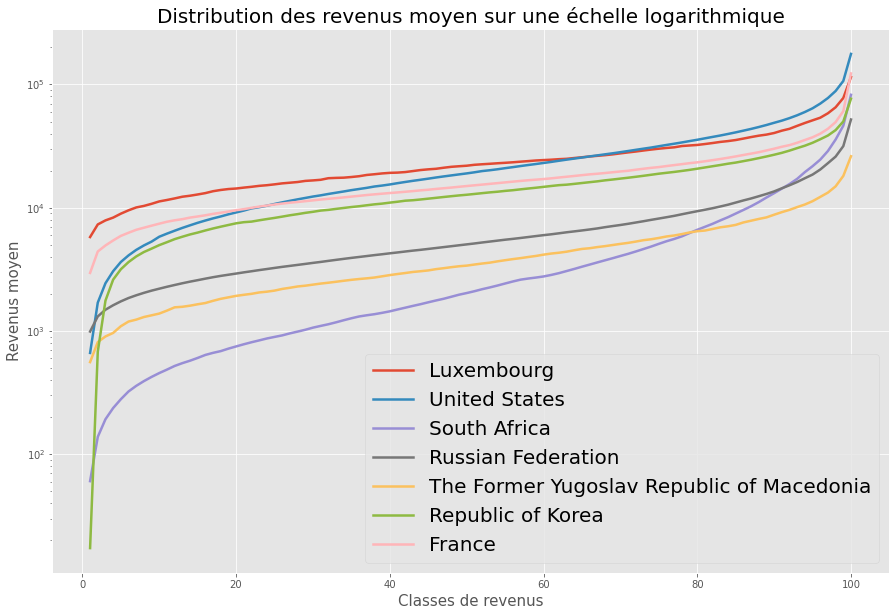

In [20]:
plt.figure(figsize=(15,10))

for x in liste_pays: 
    data = df[df.country == x]
    plt.plot(data['quantile'], data['income'], label=x, linewidth=2.5)
    plt.yscale("log") # Mise à l'échelle logarithmique de la variable 'revenus moyen'
    
    plt.title('Distribution des revenus moyen sur une échelle logarithmique', fontsize = 20)
    plt.ylabel('Revenus moyen', fontsize = 15)
    plt.xlabel('Classes de revenus', fontsize = 15)
    plt.legend(fontsize = 20)
    
plt.savefig('Graphs/Distribution_des_revenus_moyen.png')
plt.show()

- On constate que le Luxembourg, la France, la Russie, la Macédoine du Nord suivent une distribution plutôt équitable même si le Luxembourg à en moyenne un revenu plus haut que les autres pays nommé.
- En Corée du Sud, il y a une parti de la population ~ 2% qui est très faible.
- L'Afrique du Sud est bel et bien non égalitaire sur la répartition des richesse avec 20% de très pauvre et 15% de très riche.
- Les États-Unis sont aussi inégalitaire sur leurs répartitions des richesses néanmoins ils ont une plus grande base de revenus que l'Afrique du Sud.

### Représentation d'une croube de Lorenz avec nos pays sélectionné plus tôt

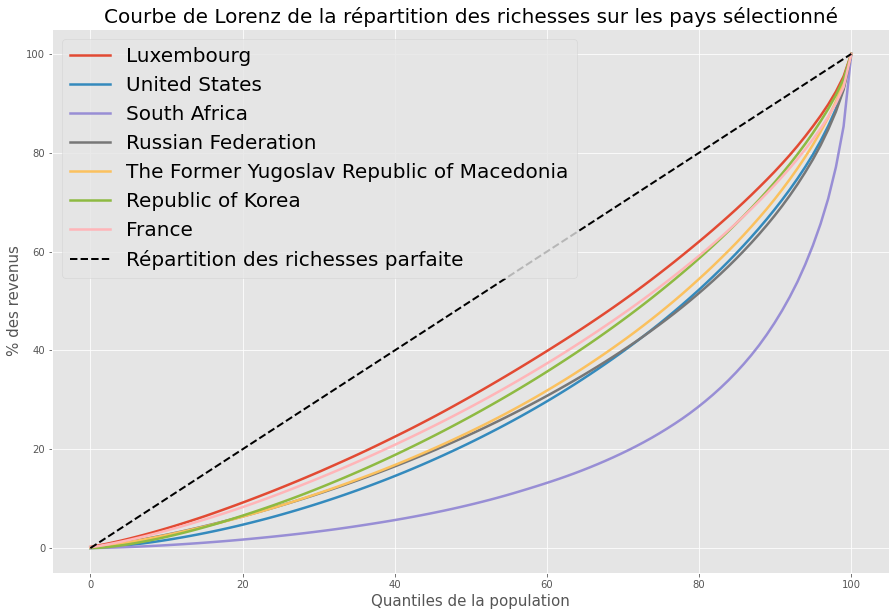

In [21]:
# Création d'une figure
plt.figure(figsize =(15,10))

# Création d'une boucle for pour itérer l'opération pour chaque pays
for pays in liste_pays:
    # Calcul des revenus totale pour chaque pays sélectionné(100 quantiles)
    revenus_total = df[df.country == pays]['income'].sum()
    
    # Transformation de la valeur obtenus en tableau narray
    dep = df[df.country == pays]['income'].values
    # Stockage du nombre de quantiles dans ma variable 'income'
    n = len(dep)
    
    # Courbe de Lorenz
    lorenz = np.cumsum((np.sort(dep)) / revenus_total)*100
    plt.plot(np.linspace(0, 100, len(lorenz)), lorenz, linewidth = 2.5, label = pays)

# Création de la '1er bisséctrice' qui aura pour rôle de nous montrer une distribution égalitaire
plt.plot([0, 100], [0, 100], linestyle = '--', color = 'black', linewidth = 2, label = 'Répartition des richesses parfaite')
plt.title('Courbe de Lorenz de la répartition des richesses sur les pays sélectionné', fontsize = 20)
plt.ylabel('% des revenus', fontsize = 15)
plt.xlabel('Quantiles de la population', fontsize = 15)
plt.legend(fontsize = 20)

plt.savefig('Graphs/Courbe_de_lorenz.png')
plt.show()

On peut voir que l'Afrique du Sud à l'une des pires répartissions des richesses dans le monde alors qu'à l'inverse le Luxembourg et celui ayant une meilleur répartition des richesses sur notre échantillon de pays sélectionné, la France sur notre échantillon est classé deuxième sur la répartition des richesses.

### Évolution de l'indice de Gini au fil des ans

In [22]:
# Importation du dataframe contenant les indices de Gini au fil des ans
gini = pd.read_csv('gini_ds2.csv', skiprows = 4)
gini.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Identification des années similaire à l'échantillon 'df'
# Stockage de toutes les variables du dataframe 'gini'
gini_columns = []
for value in gini.columns:
    gini_columns.append(value) # ajout de toutes les colonnes du dataframe 'gini' dans une liste

# Sélection des années utiles à notre échantillon de travail
gini_utile = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

# Création d'un nouveau dataframe avec les données utile à injecter dans notre dataframe de travail avec la méthode '.melt()'
gini_ajout = pd.melt(gini, id_vars = ['Country Name', 'Country Code'], value_vars = gini_utile, var_name = 'year',
                     value_name = 'gini')

gini_ajout.dropna(inplace = True)
gini_ajout.rename(columns={"Country Name" : "country", "Country Code" : "country_code"}, inplace = True)
gini_ajout['gini'] = round(gini_ajout['gini']/100, 2)
display(gini_ajout.head())
print(gini_ajout.shape)

,country,country_code,year,gini
9,Argentina,ARG,2004,0.48
10,Armenia,ARM,2004,0.38
13,Australia,AUS,2004,0.33
14,Austria,AUT,2004,0.30
15,Azerbaijan,AZE,2004,0.27


(526, 4)


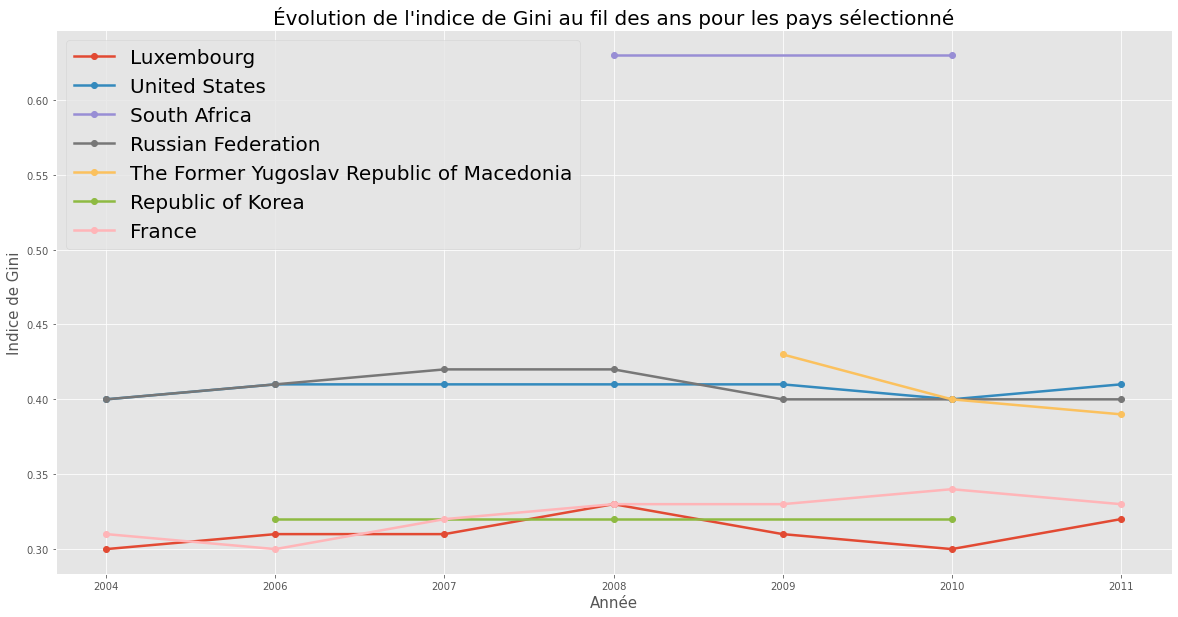

In [24]:
# Création d'une figure
plt.figure(figsize=(20,10))

# Création d'une boucle 'for' pour itérrer l'évolution de l'indice de Gini au fil des ans pour chaque pays
for pays_nom, pays_code in zip(liste_pays, code_pays):
    # Sélection des pays 
    plt.plot(gini_ajout[gini_ajout['country_code'] == pays_code]['year'],
             gini_ajout[gini_ajout['country_code'] == pays_code]['gini'], marker = 'o', linewidth = 2.5, label = pays_nom)

plt.title("Évolution de l'indice de Gini au fil des ans pour les pays sélectionné", fontsize = 20)
plt.ylabel('Indice de Gini', fontsize = 15)
plt.xlabel('Année', fontsize = 15)
plt.legend(fontsize = 20)

plt.savefig("Graphs/Évolution_de_l_indice_de_Gini_au_fil_des_ans_pour_les_pays_sélectionné.png")
plt.show()

### Classement des pays par indice de Gini

In [25]:
# Classement des pays par indice de Gini
# Quelle est la moyenne de l'indice de Gini dans notre échantillon de pays
moy_gini = round(df['gini'].unique().mean(), 2)
print("La moyenne de l'indice de gini sur l'ensemble de notre échantillon de pays est de {}".format(moy_gini))

La moyenne de l'indice de gini sur l'ensemble de notre échantillon de pays est de 0.41


In [26]:
# Création d'un dataframe en supprimant les rows en trop
# Copie de notre dataframe
df_gini_class = df.copy()

# Mise à l'écart des doublons dans notre variable 'country_code'
df_gini_class.drop_duplicates(subset = ['country_code'], inplace = True)

# Classement des pays selon leurs indice de Gini avec la fonction '.rank()'
# la méthode 'first' indiquera que les indices auront le même classement en cas d'égalité
df_gini_class['rank_by_gini'] = df_gini_class['gini'].rank(method='first')

df_gini_class.reset_index(inplace = True)
del df_gini_class['index']

In [27]:
# CLassement des pays dans notre échantillon par indice de Gini & ou se trouve la France ?
display(df_gini_class[['country', 'gini', 'rank_by_gini']].sort_values('rank_by_gini')[:5])
display(df_gini_class[['country', 'gini', 'rank_by_gini']].sort_values('rank_by_gini', ascending = False)[:5])
display(df_gini_class[['country_code', 'gini', 'rank_by_gini']][df_gini_class['country_code'] == 'FRA'])

,country,gini,rank_by_gini
96,Slovenia,0.24,1.0
25,Denmark,0.25,2.0
95,Slovakia,0.25,3.0
23,Czech Republic,0.26,4.0
81,Norway,0.27,5.0


,country,gini,rank_by_gini
114,South Africa,0.63,116.0
39,Guatemala,0.57,115.0
40,Honduras,0.56,114.0
14,Central African,0.56,113.0
20,Colombia,0.55,112.0


,country_code,gini,rank_by_gini
33,FRA,0.33,37.0


#### La France se classe à la 37ème place des pays qui partage le plus équitablement ses richesses avec sa population.

In [28]:
# Exportation de mon dataframe de travail
df.to_csv('df.csv', index = False)